In [1]:
import matplotlib
%matplotlib inline
import seaborn as sns


In [2]:
# library imports
import numpy as np
import pandas as pd
import scipy as sc

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split #training and testing data split
from sklearn.svm import SVR
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import VarianceThreshold
from sklearn import preprocessing
from sklearn import utils
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from datetime import datetime, timedelta
from sklearn.metrics import roc_auc_score
 
import time

In [3]:
# Load Train and Test CSV

headerNames = ["id","Gender","age","hypertension","heart_disease","ever_married","work_type",
               "Residence_type","avg_glucose_level","bmi","smoking_status","stroke"]
prefix = "./data/"

# ID cannot be used for prediction 
# hence setting index_col = 0 takes care of removing ID field from dataset in both train and test dataframes.
traindf = pd.read_csv(prefix + "train.csv", header=None, delim_whitespace=False,  names=headerNames, index_col=0,) 
testdf = pd.read_csv(prefix + "test.csv", header=None, delim_whitespace=False,  names=headerNames, index_col=0,)
testdf = testdf.drop('stroke', axis=1)

#sample data for a quick run
#traindf = traindf.sample(frac=0.25, replace=True)

print(traindf.shape)
print(testdf.shape)

(43400, 11)
(18601, 10)


In [4]:
traindf.head(10)

,Gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0
32257,Female,47.0,0,0,Yes,Private,Urban,210.95,50.1,NaN,0
52800,Female,52.0,0,0,Yes,Private,Urban,77.59,17.7,formerly smoked,0
41413,Female,75.0,0,1,Yes,Self-employed,Rural,243.53,27.0,never smoked,0
15266,Female,32.0,0,0,Yes,Private,Rural,77.67,32.3,smokes,0


In [5]:
# Gender, Age, BMI to heart rate data
headerNames = ["Gender","Age","Height","Weight","HR_max"]
prefix = "./data/"

# ID cannot be used for prediction 
# hence setting index_col = 0 takes care of removing ID field from dataset in both train and test dataframes.
hrratetraindf = pd.read_csv(prefix + "demog-max-hrrate.csv", header=None, delim_whitespace=False,  names=headerNames, ) #index_col=0, 
hrratetraindf['Weight'] = hrratetraindf['Weight'].astype(float)

hrratetraindf['Height'] = hrratetraindf['Height'].astype(float)
hrratetraindf.loc[hrratetraindf['Height'] > 10, 'Height'] = hrratetraindf['Height']/100


hrratetraindf['BMI'] = hrratetraindf['Weight'] / (hrratetraindf['Height'] * hrratetraindf['Height'])

print(hrratetraindf.shape)
hrratetraindf.head(100)


(373, 6)


,Gender,Age,Height,Weight,HR_max,BMI
0,1,28,1.820,77.00,189.0,23.245985
1,0,21,1.750,87.50,181.0,28.571429
2,1,21,1.840,89.00,197.0,26.287807
3,1,20,1.740,68.20,199.0,22.526093
4,0,20,1.750,74.00,201.0,24.163265
5,1,19,1.820,72.80,200.0,21.978022
6,0,22,1.580,65.80,199.0,26.357955
7,0,22,1.600,65.20,194.0,25.468750
8,0,25,1.650,57.60,176.0,21.157025
9,1,25,1.830,85.00,190.0,25.381469


In [6]:
# Set of Unique Values for stroke - it is a binary classification problem
print(traindf['Gender'].unique())
print(traindf['ever_married'].unique())
print(traindf['work_type'].unique())
print(traindf['Residence_type'].unique())
print(traindf['smoking_status'].unique())
print(traindf['stroke'].unique())

traindf.columns

['Male' 'Female' 'Other']
['No' 'Yes']
['children' 'Private' 'Never_worked' 'Self-employed' 'Govt_job']
['Rural' 'Urban']
[nan 'never smoked' 'formerly smoked' 'smokes']
[0 1]


Index(['Gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [7]:
# Train Data Stats
traindf.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,43400.000000,43400.000000,43400.000000,43400.000000,41938.000000,43400.000000
mean,42.217894,0.093571,0.047512,104.482750,28.605038,0.018041
std,22.519649,0.291235,0.212733,43.111751,7.770020,0.133103
min,0.080000,0.000000,0.000000,55.000000,10.100000,0.000000
25%,24.000000,0.000000,0.000000,77.540000,23.200000,0.000000
50%,44.000000,0.000000,0.000000,91.580000,27.700000,0.000000
75%,60.000000,0.000000,0.000000,112.070000,32.900000,0.000000
max,82.000000,1.000000,1.000000,291.050000,97.600000,1.000000


In [8]:
# stats of categorical features
traindf.describe(include=['O'])

,Gender,ever_married,work_type,Residence_type,smoking_status
count,43400,43400,43400,43400,30108
unique,3,2,5,2,3
top,Female,Yes,Private,Urban,never smoked
freq,25665,27938,24834,21756,16053


In [9]:
# for starters, fill every nan value with mean column values across the dataset.
#traindf = traindf.dropna() 
#testdf = testdf.dropna() 

#fill NaN values with 0.0 for training and test
traindf['bmi'].fillna(0.0, inplace=True) 
testdf['bmi'].fillna(0.0, inplace=True) 

#traindf['gender'].fillna(traindf['gender'].dropna().mean(), inplace=True)

print(traindf.shape)
print(testdf.shape)

(43400, 11)
(18601, 10)


In [10]:
# Feature Engineering - Convert Categorical Data to Numeric > Gender
# convert Gender to numeric

#Train Data
traindf['Gender_numeric']  = 0.0 # default value
traindf.loc[traindf['Gender'] == 'Male', 'Gender_numeric'] = 1.0
traindf.loc[traindf['Gender'] == 'Female', 'Gender_numeric'] = 2.0
traindf.loc[traindf['Gender'] == 'Other', 'Gender_numeric'] = 3.0
traindf = traindf.drop('Gender', axis=1)

#Test Data
testdf['Gender_numeric']  = 0.0 # default value
testdf.loc[testdf['Gender'] == 'Male', 'Gender_numeric'] = 1.0
testdf.loc[testdf['Gender'] == 'Female', 'Gender_numeric'] = 2.0
testdf.loc[testdf['Gender'] == 'Other', 'Gender_numeric'] = 3.0
testdf = testdf.drop('Gender', axis=1)

In [11]:
# Feature Engineering - Convert Categorical Data to Numeric > ever_married
# convert ever_married to numeric

#Train Data
traindf['ever_married_numeric']  = 0.0 # default value
traindf.loc[traindf['ever_married'] == 'No', 'ever_married_numeric'] = 1.0
traindf.loc[traindf['ever_married'] == 'Yes', 'ever_married_numeric'] = 2.0
traindf = traindf.drop('ever_married', axis=1)

#Test Data
testdf['ever_married_numeric']  = 0.0 # default value
testdf.loc[testdf['ever_married'] == 'No', 'ever_married_numeric'] = 1.0
testdf.loc[testdf['ever_married'] == 'Yes', 'ever_married_numeric'] = 2.0
testdf = testdf.drop('ever_married', axis=1)


In [12]:
# Feature Engineering - Convert Categorical Data to Numeric > work_type
# convert work_type to numeric
#['children' 'Private' 'Never_worked' 'Self-employed' 'Govt_job']

#Train Data
traindf['work_type_numeric']  = 0.0 # default value
traindf.loc[traindf['work_type'] == 'children', 'work_type_numeric'] = 1.0
traindf.loc[traindf['work_type'] == 'Private', 'work_type_numeric'] = 2.0
traindf.loc[traindf['work_type'] == 'Never_worked', 'work_type_numeric'] = 3.0
traindf.loc[traindf['work_type'] == 'Self-employed', 'work_type_numeric'] = 4.0
traindf.loc[traindf['work_type'] == 'Govt_job', 'work_type_numeric'] = 5.0
traindf = traindf.drop('work_type', axis=1)

#Test Data
testdf['work_type_numeric']  = 0.0 # default value
testdf.loc[testdf['work_type'] == 'children', 'work_type_numeric'] = 1.0
testdf.loc[testdf['work_type'] == 'Private', 'work_type_numeric'] = 2.0
testdf.loc[testdf['work_type'] == 'Never_worked', 'work_type_numeric'] = 3.0
testdf.loc[testdf['work_type'] == 'Self-employed', 'work_type_numeric'] = 4.0
testdf.loc[testdf['work_type'] == 'Govt_job', 'work_type_numeric'] = 5.0
testdf = testdf.drop('work_type', axis=1)


In [13]:
# Feature Engineering - Convert Categorical Data to Numeric > Residence_type
# convert Residence_type to numeric
#['Rural' 'Urban']

#Train Data
traindf['Residence_type_numeric']  = 0.0 # default value
traindf.loc[traindf['Residence_type'] == 'Rural', 'Residence_type_numeric'] = 1.0
traindf.loc[traindf['Residence_type'] == 'Urban', 'Residence_type_numeric'] = 2.0
traindf = traindf.drop('Residence_type', axis=1)

#Test Data
testdf['Residence_type_numeric']  = 0.0 # default value
testdf.loc[testdf['Residence_type'] == 'Rural', 'Residence_type_numeric'] = 1.0
testdf.loc[testdf['Residence_type'] == 'Urban', 'Residence_type_numeric'] = 2.0
testdf = testdf.drop('Residence_type', axis=1)


In [14]:

# Feature Engineering - Convert Categorical Data to Numeric > smoking_status
# convert smoking_status to numeric
#[nan 'never smoked' 'formerly smoked' 'smokes']

#Train Data
traindf['smoking_status_numeric']  = 0.0 # default value
traindf.loc[traindf['smoking_status'] == 'never smoked', 'smoking_status_numeric'] = 1.0
traindf.loc[traindf['smoking_status'] == 'formerly smoked', 'smoking_status_numeric'] = 2.0
traindf.loc[traindf['smoking_status'] == 'smokes', 'smoking_status_numeric'] = 3.0
traindf = traindf.drop('smoking_status', axis=1)

#Test Data
testdf['smoking_status_numeric']  = 0.0 # default value
testdf.loc[testdf['smoking_status'] == 'never smoked', 'smoking_status_numeric'] = 1.0
testdf.loc[testdf['smoking_status'] == 'formerly smoked', 'smoking_status_numeric'] = 2.0
testdf.loc[testdf['smoking_status'] == 'smokes', 'smoking_status_numeric'] = 3.0
testdf = testdf.drop('smoking_status', axis=1)
print(testdf['smoking_status_numeric'].unique())

[ 2.  0.  1.  3.]


In [15]:
# convert integer based columns to float
traindf['hypertension'] = traindf['hypertension'].astype(float)
traindf['heart_disease'] = traindf['heart_disease'].astype(float)
traindf['stroke'] = traindf['stroke'].astype(float)

testdf['hypertension'] = testdf['hypertension'].astype(float)
testdf['heart_disease'] = testdf['heart_disease'].astype(float)

In [16]:
# removing glucose level - not collecting data real time
traindf = traindf.drop('avg_glucose_level', axis=1)
testdf = testdf.drop('avg_glucose_level', axis=1)


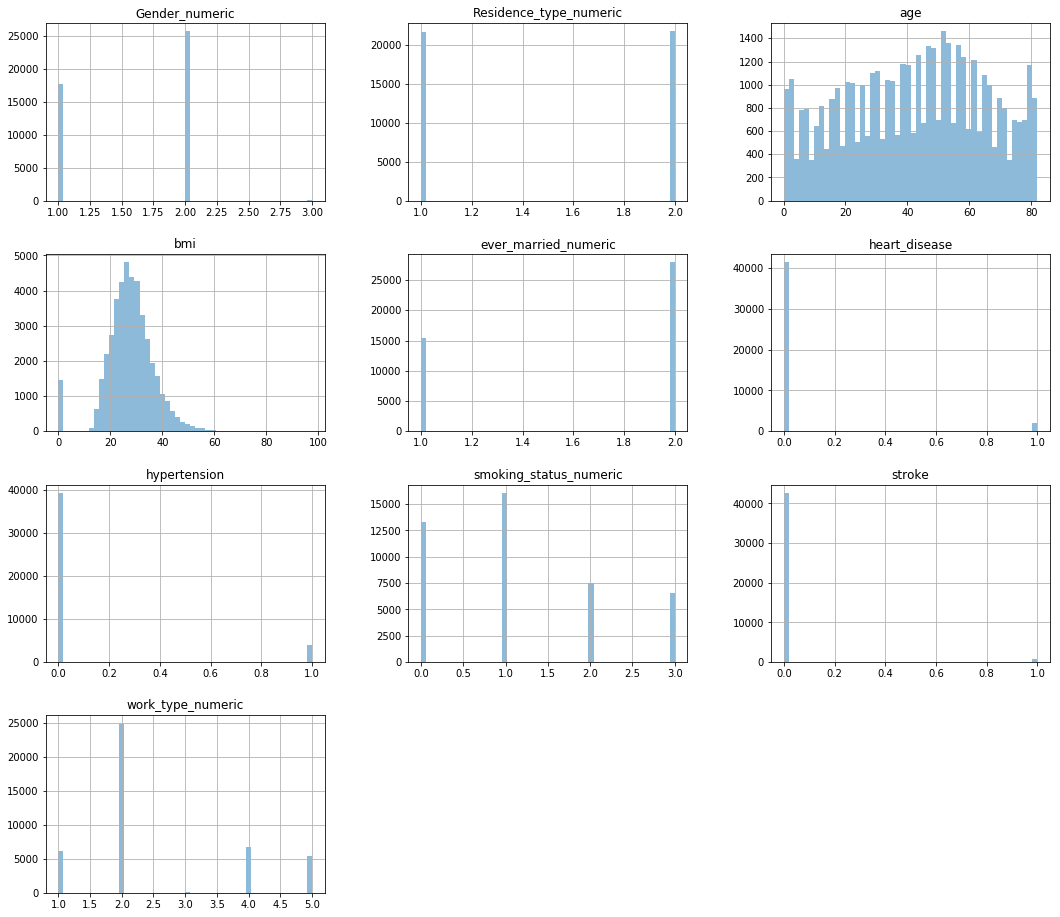

In [17]:
fig=plt.gcf()
traindf.hist(figsize=(18, 16), alpha=0.5, bins=50)
plt.show()
fig.savefig('histograms.png')

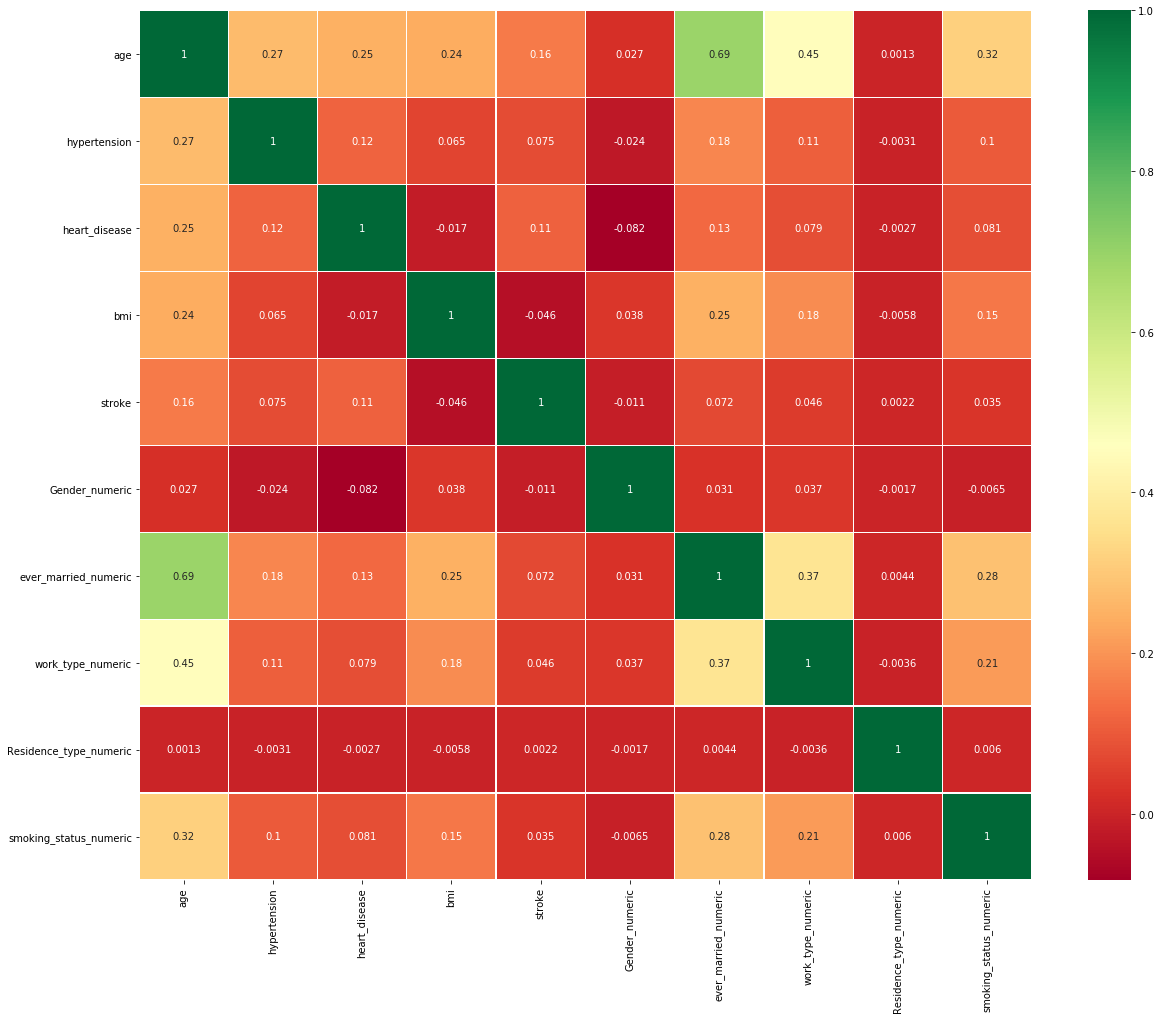

In [18]:
sns.heatmap(traindf.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(20,16)
#plt.show()
fig.savefig('Correlation_before.png')

In [19]:
#drop based on very low positive or negative correlation

#traindf = traindf.drop('Residence_type_numeric', axis=1)
#testdf = testdf.drop('Residence_type_numeric', axis=1)

#traindf = traindf.drop('Gender_numeric', axis=1)
#testdf = testdf.drop('Gender_numeric', axis=1)


#traindf = traindf.drop('smoking_status_numeric', axis=1)
#testdf = testdf.drop('smoking_status_numeric', axis=1)


#traindf = traindf.drop('work_type_numeric', axis=1)
#testdf = testdf.drop('work_type_numeric', axis=1)
'''
traindf = traindf.drop('bmi', axis=1)
testdf = testdf.drop('bmi', axis=1)
'''

"\ntraindf = traindf.drop('bmi', axis=1)\ntestdf = testdf.drop('bmi', axis=1)\n"

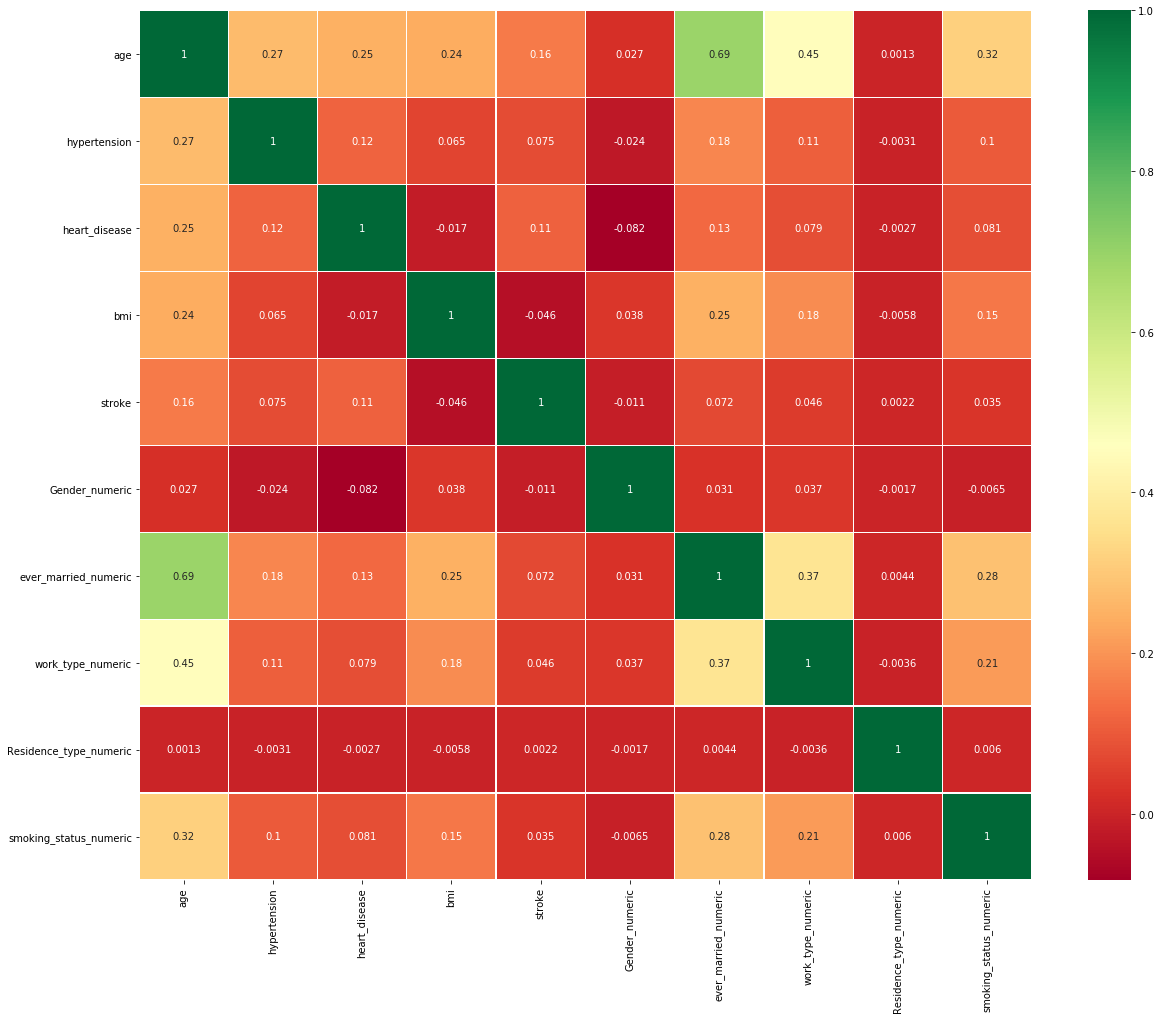

In [20]:
sns.heatmap(traindf.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(20,16)
plt.show()
fig.savefig('Correlation_after.png')

In [21]:
# extract features from training set - all columns except 'stroke'
train_features = traindf.loc[:, traindf.columns != 'stroke']
print(train_features.columns)

Index(['age', 'hypertension', 'heart_disease', 'bmi', 'Gender_numeric',
       'ever_married_numeric', 'work_type_numeric', 'Residence_type_numeric',
       'smoking_status_numeric'],
      dtype='object')


In [22]:
# extract label from training set - Approved
train_label = traindf.loc[:, traindf.columns == 'stroke']
train_label.columns

Index(['stroke'], dtype='object')

In [23]:
# check for null valued columns
print("Train Data -any null ?? ")
print(traindf.columns[traindf.isnull().any()].tolist())
print("Test Data -any null ?? ")
print(testdf.columns[testdf.isnull().any()].tolist())
#check test columns
print(testdf.columns)

Train Data -any null ?? 
[]
Test Data -any null ?? 
[]
Index(['age', 'hypertension', 'heart_disease', 'bmi', 'Gender_numeric',
       'ever_married_numeric', 'work_type_numeric', 'Residence_type_numeric',
       'smoking_status_numeric'],
      dtype='object')


In [24]:
'''
# define the parameter values that should be searched
n_estimators_range = list(range(80, 100))
#=5, n_estimators=30, min_samples_split=2
max_depth_range = list(range(1,20))
min_samples_split_range = list(range(2,20))
criterion_range=['entropy','gini']
max_features=list(range(1,5))
max_leaf_nodes=list(range(1,10))

from sklearn.grid_search import RandomizedSearchCV
from sklearn.grid_search import GridSearchCV
# specify "parameter distributions" rather than a "parameter grid"
model = RandomForestClassifier(n_estimators=100)
param_dict = dict(n_estimators=n_estimators_range,max_depth=max_depth_range,
                  min_samples_split=min_samples_split_range,
                  max_leaf_nodes=max_leaf_nodes,criterion=criterion_range, max_features=max_features)

conv_X = pd.get_dummies(train_features.iloc[:, :]) 
conv_Y = pd.get_dummies(train_label['stroke']) 
#print(conv_Y)
#print(conv_X)

# n_iter controls the number of searches
#rand = GridSearchCV(model, param_dict, cv=10, scoring='roc_auc',  n_jobs=-1)
rand = RandomizedSearchCV(model, param_dict, cv=10, scoring='roc_auc', n_iter=10, random_state=5)
rand.fit(conv_X, conv_Y)
print("GRID SCORES >>> ",rand.grid_scores_)

# examine the best model
print("BEST SCORE >>> ",rand.best_score_)
print("BEST PARAMETERS >>> ",rand.best_params_)
'''

'\n# define the parameter values that should be searched\nn_estimators_range = list(range(80, 100))\n#=5, n_estimators=30, min_samples_split=2\nmax_depth_range = list(range(1,20))\nmin_samples_split_range = list(range(2,20))\ncriterion_range=[\'entropy\',\'gini\']\nmax_features=list(range(1,5))\nmax_leaf_nodes=list(range(1,10))\n\nfrom sklearn.grid_search import RandomizedSearchCV\nfrom sklearn.grid_search import GridSearchCV\n# specify "parameter distributions" rather than a "parameter grid"\nmodel = RandomForestClassifier(n_estimators=100)\nparam_dict = dict(n_estimators=n_estimators_range,max_depth=max_depth_range,\n                  min_samples_split=min_samples_split_range,\n                  max_leaf_nodes=max_leaf_nodes,criterion=criterion_range, max_features=max_features)\n\nconv_X = pd.get_dummies(train_features.iloc[:, :]) \nconv_Y = pd.get_dummies(train_label[\'stroke\']) \n#print(conv_Y)\n#print(conv_X)\n\n# n_iter controls the number of searches\n#rand = GridSearchCV(model

In [25]:
## Prediction model 
print(hrratetraindf.columns)
hr_train_features = hrratetraindf.loc[:, hrratetraindf.columns != 'HR_max']
hr_train_features= hr_train_features.drop('Height',axis=1)
hr_train_features= hr_train_features.drop('Weight',axis=1)

hr_train_features['Gender'] = hr_train_features['Gender'].astype(float)
hr_train_features['Age'] = hr_train_features['Age'].astype(float)

print(hr_train_features.columns)
print(hr_train_features.head(10))
# extract label from training set - Approved
hr_train_label = hrratetraindf.loc[:, hrratetraindf.columns == 'HR_max']
hr_train_label['HR_max'] = hr_train_label['HR_max'].astype(float)
print(hr_train_label.columns)
0
hr_train_label['HR_max'].fillna(hr_train_label['HR_max'].dropna().mean(), inplace=True)

# check for null valued columns
print("Train Data -any null ?? ")
print(hr_train_features.columns[hr_train_features.isnull().any()].tolist())
print("Label Data -any null ?? ")
print(hr_train_label.columns[hr_train_label.isnull().any()].tolist())


Index(['Gender', 'Age', 'Height', 'Weight', 'HR_max', 'BMI'], dtype='object')
Index(['Gender', 'Age', 'BMI'], dtype='object')
   Gender   Age        BMI
0     1.0  28.0  23.245985
1     0.0  21.0  28.571429
2     1.0  21.0  26.287807
3     1.0  20.0  22.526093
4     0.0  20.0  24.163265
5     1.0  19.0  21.978022
6     0.0  22.0  26.357955
7     0.0  22.0  25.468750
8     0.0  25.0  21.157025
9     1.0  25.0  25.381469
Index(['HR_max'], dtype='object')
Train Data -any null ?? 
[]
Label Data -any null ?? 
[]


C:\ProgramData\Anaconda3-5.0.1\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3-5.0.1\lib\site-packages\pandas\core\generic.py:3660: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [26]:
# determine hr_max using hrratedata
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
hr_model = make_pipeline(StandardScaler(with_std=True, with_mean=True),  RandomForestRegressor(max_depth=5, n_estimators=98, max_features=2,
                                                        max_leaf_nodes=7,min_samples_split=15, criterion='mse'))

hr_model.fit(hr_train_features, hr_train_label)
hr_train_pred = hr_model.predict(hr_train_features)
print(hr_train_pred)
print ("RMSE :: " , np.sqrt(mean_squared_error(hr_train_label, hr_train_pred))) # Training RMSE


C:\ProgramData\Anaconda3-5.0.1\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[ 186.18282403  186.8663857   186.8663857   187.32258766  187.17227209
  187.56666203  186.16998481  186.16998481  184.6524836   185.70039629
  184.79006178  163.0661517   187.79377619  185.95684932  185.35102613
  184.46952734  185.11605424  185.65465822  185.87151732  187.38676012
  185.95684932  179.6070646   181.65696773  181.97706551  185.87151732
  185.87151732  185.42678868  181.71284528  185.77863923  185.04204872
  185.87151732  185.70039629  185.87151732  161.0231614   184.02401212
  186.18282403  185.42678868  181.92970438  185.73245895  186.56501645
  188.0221768   185.04399305  181.92970438  185.82216368  185.89724815
  186.18282403  186.18282403  186.59233593  185.42115225  187.26141735
  187.72960373  187.79377619  187.32258766  187.98347296  188.42919287
  186.98729764  187.98347296  186.12533121  159.91770051  149.48729767
  185.59878067  185.57774579  187.20043313  185.68411266  186.28875511
  186.37920044  186.98729764  186.18282403  186.98729764  186.18282403
  160.

In [27]:
## predict hr rate for original training data and plug it into training data
print("train columns ",train_features.columns)
hr_train_features = train_features
hr_train_features= hr_train_features.drop('hypertension', axis=1)
hr_train_features= hr_train_features.drop('heart_disease', axis=1)
hr_train_features= hr_train_features.drop('ever_married_numeric', axis=1)

hr_train_features= hr_train_features.drop('work_type_numeric', axis=1)
hr_train_features= hr_train_features.drop('smoking_status_numeric', axis=1)
hr_train_features= hr_train_features.drop('Residence_type_numeric', axis=1)

print("hr train ",hr_train_features.columns)

train_features['predicted_hr_max']=hr_model.predict(hr_train_features)

traindf['hr'] = train_features['predicted_hr_max']
traindf.loc[traindf['stroke'] == 0.0, 'hr'] = train_features['predicted_hr_max'] - 70; # normal is less than 120


train_features['hr'] = traindf['hr']
train_features = train_features.drop('predicted_hr_max', axis=1)
#print(train_features.columns)
print(train_features.columns)

## predict hr rate for original test data and plug it into test data
'''print("test columns ",testdf.columns)
hr_test_features = testdf

hr_test_features= hr_test_features.drop('hypertension', axis=1)
hr_test_features= hr_test_features.drop('heart_disease', axis=1)
hr_test_features= hr_test_features.drop('ever_married_numeric', axis=1)
hr_test_features= hr_test_features.drop('work_type_numeric', axis=1)
hr_test_features= hr_test_features.drop('smoking_status_numeric', axis=1)
hr_test_features= hr_test_features.drop('Residence_type_numeric', axis=1)



print(hr_test_features.columns)
testdf['predicted_hr_max']=hr_model.predict(hr_test_features)
testdf['hr'] = testdf['predicted_hr_max']
testdf.loc[traindf['stroke'] == 0.0, 'hr'] = train_features['predicted_hr_max'] - 70; # normal is less than 120

#print(train_features.columns)
print(testdf)
'''

train columns  Index(['age', 'hypertension', 'heart_disease', 'bmi', 'Gender_numeric',
       'ever_married_numeric', 'work_type_numeric', 'Residence_type_numeric',
       'smoking_status_numeric'],
      dtype='object')
hr train  Index(['age', 'bmi', 'Gender_numeric'], dtype='object')
Index(['age', 'hypertension', 'heart_disease', 'bmi', 'Gender_numeric',
       'ever_married_numeric', 'work_type_numeric', 'Residence_type_numeric',
       'smoking_status_numeric', 'hr'],
      dtype='object')


'print("test columns ",testdf.columns)\nhr_test_features = testdf\n\nhr_test_features= hr_test_features.drop(\'hypertension\', axis=1)\nhr_test_features= hr_test_features.drop(\'heart_disease\', axis=1)\nhr_test_features= hr_test_features.drop(\'ever_married_numeric\', axis=1)\nhr_test_features= hr_test_features.drop(\'work_type_numeric\', axis=1)\nhr_test_features= hr_test_features.drop(\'smoking_status_numeric\', axis=1)\nhr_test_features= hr_test_features.drop(\'Residence_type_numeric\', axis=1)\n\n\n\nprint(hr_test_features.columns)\ntestdf[\'predicted_hr_max\']=hr_model.predict(hr_test_features)\ntestdf[\'hr\'] = testdf[\'predicted_hr_max\']\ntestdf.loc[traindf[\'stroke\'] == 0.0, \'hr\'] = train_features[\'predicted_hr_max\'] - 70; # normal is less than 120\n\n#print(train_features.columns)\nprint(testdf)\n'

In [28]:
traindf.head(10)

,age,hypertension,heart_disease,bmi,stroke,Gender_numeric,ever_married_numeric,work_type_numeric,Residence_type_numeric,smoking_status_numeric,hr
id,,,,,,,,,,,
30669,3.0,0.0,0.0,18.0,0.0,1.0,1.0,1.0,1.0,0.0,117.793776
30468,58.0,1.0,0.0,39.2,0.0,1.0,2.0,2.0,2.0,1.0,107.340973
16523,8.0,0.0,0.0,17.6,0.0,2.0,1.0,2.0,2.0,0.0,117.793776
56543,70.0,0.0,0.0,35.9,0.0,2.0,2.0,2.0,1.0,2.0,110.880913
46136,14.0,0.0,0.0,19.1,0.0,1.0,1.0,3.0,1.0,0.0,117.793776
32257,47.0,0.0,0.0,50.1,0.0,2.0,2.0,2.0,2.0,0.0,89.297434
52800,52.0,0.0,0.0,17.7,0.0,2.0,2.0,2.0,2.0,2.0,117.793776
41413,75.0,0.0,1.0,27.0,0.0,2.0,2.0,4.0,1.0,1.0,115.653338
15266,32.0,0.0,0.0,32.3,0.0,2.0,2.0,2.0,1.0,3.0,115.653338


In [29]:
#Train the model with best parameters of RF
# best params for RF using randomizedCV
# {StandardScaler(with_std=True), PCA(n_components=10), RandomForestClassifier(max_depth=5, n_estimators=85, min_samples_split=2) #best 0.783
#BEST PARAMETERS >>>  {'n_estimators': 87, 'min_samples_split': 5, 'max_depth': 6}
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
model = make_pipeline(StandardScaler(with_std=True, with_mean=True),  RandomForestClassifier(max_depth=2, n_estimators=98, max_features=2,
                                                        max_leaf_nodes=7,min_samples_split=15, criterion='entropy'))
#
model.fit(train_features, train_label)
train_pred = model.predict(train_features)
print(metrics.accuracy_score(train_label, train_pred)) # Training Accuracy Score
print (np.sqrt(mean_squared_error(train_label, train_pred))) # Training RMSE
print(roc_auc_score(train_label, train_pred)) # AUC-ROC values

C:\ProgramData\Anaconda3-5.0.1\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


0.987534562212
0.111648724973
0.654533844189


In [30]:
print(train_features.columns)
print(testdf.columns)
#Predict with test data - predict probabilities
'''test_pred = model.predict_proba(testdf) #test features are all in testdf

print(test_pred) # Predicted Values
'''
#print(np.unique(test_pred)) # unique values

Index(['age', 'hypertension', 'heart_disease', 'bmi', 'Gender_numeric',
       'ever_married_numeric', 'work_type_numeric', 'Residence_type_numeric',
       'smoking_status_numeric', 'hr'],
      dtype='object')
Index(['age', 'hypertension', 'heart_disease', 'bmi', 'Gender_numeric',
       'ever_married_numeric', 'work_type_numeric', 'Residence_type_numeric',
       'smoking_status_numeric'],
      dtype='object')


'test_pred = model.predict_proba(testdf) #test features are all in testdf\n\nprint(test_pred) # Predicted Values\n'

In [32]:
#Prepare outputdf to populate CSV
#output df
#print(test_pred.classes_)
#print(testdf.index)
#print(test_pred[:,1])
'''
outputdf = pd.DataFrame()
outputdf['id'] = testdf.index
outputdf['stroke'] = test_pred[:,1]
'''

"\noutputdf = pd.DataFrame()\noutputdf['id'] = testdf.index\noutputdf['stroke'] = test_pred[:,1]\n"

In [33]:
#Save to CSV file in submission format

#outputdf.to_csv("output/output_rf"+str(time.time())+".csv", sep=",", index=False)